In [1]:
import numba, os, sys, time, pickle, resource, copy, subprocess, multiprocessing
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from datetime import datetime, timedelta
from sys import path
from tqdm.auto import tqdm
import pickle
import glob

from numpy.random import Generator, PCG64

import sunpy
from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
from astropy.io import fits
import importlib

crobar_path = os.path.join('../crobar/python_modules/')
path.append(crobar_path)
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

path.append('../codebase')
from aia_noise import aia_noise
from misc_io import get_croprs, get_map, get_bounds, bounds2grid

ebtel_path ="../ebtelPlusPlus/" #nanoflare->ebtelplusplus
ebtel_bin_path = ebtel_path+"bin/ebtel++.run"

plt.rcParams.update({'font.size': 18,'figure.figsize':[16,8],'image.origin':'lower'})

In [2]:
newpoints = False # Generate a new set of footpoints (requires a full simulation rerun)
newtrace = False # Retrace the field lines (e.g., if alpha changes)
newfilter = False # Refilter the traced loops to cull those that are too close together
newmatrix = False # Compute a new forward matrix for CROBAR inversion
run_amat_gen = False # Generate the general forward matrix amat(x,y,loop,segment)
heating_model_gen=True # Regenerate the heating for each loop
run_ebtel = True # Run the EBTEL heating simulations
run_batch = True # Generate full set of images

In [3]:
# Save files and arguments that need to go in the save file names:
save_dir = '../files/save'
magnetogram_dir = '../files/data'
emission_dir = '../files/save'

# note, the following two files need to have been created externally. 
magnetogram_name = 'hmi.m_45s.2020.04.28_11_13_30_TAI.magnetogram.fits'
emis_name = 'radloss_iswat_042820.fits'
alpha = 3/1.0e11
alphastr = str(round(alpha/1.0e-11,3))

date = '2020/04/28 11:13:30'
datestr = '20200428_111330'

footpoint_savefile = os.path.join(save_dir,'footpoints_'+datestr+'.npz')
loop_savefile = os.path.join(save_dir,'loops_'+datestr+'_'+alphastr+'.npz')
loopid_savefile = os.path.join(save_dir,'loopids_'+datestr+'_'+alphastr+'.npz')
emis_configfile = os.path.join(save_dir,'emconfig_'+'_'+datestr+'_'+alphastr+'.npz')
emis_savefile = os.path.join(save_dir,'em3d_'+emis_name[0:-4]+'_'+datestr+'_'+alphastr+'.npz')
limb_savefile = os.path.join(save_dir,'limb_mask_'+datestr+'_'+alphastr+'.npz')
area_savefile = os.path.join(save_dir,'loop_areas_3.0.npz')
em3d_savefile = os.path.join(save_dir,'hmap_cube_bindown3.npz')

In [4]:
footpoint_config = dict(np.load(footpoint_savefile,allow_pickle=False))
loop_config = dict(np.load(loop_savefile,allow_pickle=False))
emis_config = dict(np.load(emis_configfile,allow_pickle=False))
loopid_info = dict(np.load(loopid_savefile,allow_pickle=False))
loop_areas = dict(np.load(area_savefile,allow_pickle=False))
em3d_output = dict(np.load(emis_savefile,allow_pickle=False))

In [5]:
length_unit = u.Unit(str(footpoint_config['length_unit']))
pos_unit = u.Unit(str(footpoint_config['pos_unit']))

magnetogram_path = os.path.join(magnetogram_dir,str(footpoint_config['magnetogram_name']))
emis_path = os.path.join(emission_dir,str(emis_config['emis_name']))

In [6]:
cropr, cropr_emis = get_croprs(footpoint_config)
magnetogram = get_map(magnetogram_path, cropr)
emis_map = get_map(emis_path, cropr_emis)

In [7]:
gfac = 1.0/2.8
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
flux_factor = loop_config['dvox'][0]*loop_config['dvox'][1]
rsun_cm = magnetogram.center.rsun.to(length_unit).value
footpoint_config['rsun_cm'] = rsun_cm

In [8]:
# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

In [9]:
bounds0, tracer_bounds = get_bounds(mag_coords, footpoint_config, loop_config)
# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,loop_config['dvox'],offsets=footpoint_config['bounds_offset'],pad=loop_config['vox_boundpad'])
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,loop_config['dvox']*loop_config['flt_dvox_fac'],offsets=footpoint_config['bounds_offset'])
vox0, dvox, nvox = vox_grid.origin, np.diag(vox_grid.fwd), vox_grid.dims
print(vox0, dvox, nvox)

[-1.64535932e+10 -1.69383115e+10 -4.22539499e+09] [14000000. 14000000. 14000000.] [2298 2399 1951]


In [10]:
# Unpack the coordinates from the loop config file:
fieldline_coords0 = [loop_config['fieldlines0'][loop_config['fieldline_indices0']==i] for i in range(0,loop_config['fieldline_indices0'][-1])]

if(newfilter):
	# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
	[fieldlines_resamp,lengths] = resample_loops(fieldline_coords0,tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
	
	# Filter out loops whose footpoints fall too close together:
	[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, 
													  lmin=loop_config['min_length'], 
													  zmin = loop_config['min_height'], rcurv=rsun_cm)
	fieldline_indices = np.hstack([i*np.ones(fieldlines_filter[i].shape[0],dtype=np.int32) for i in range(0,len(fieldlines_filter))])
	loop_config['fieldline_indices'] = fieldline_indices
	loop_config['fieldlines_filter'] = np.vstack(fieldlines_filter)
	loop_config['lengths_filter'] = np.hstack(lengths_filter)
	np.savez_compressed(loop_savefile,**loop_config)
else:
	fieldlines_filter = [loop_config['fieldlines_filter'][loop_config['fieldline_indices']==i] for i in tqdm(range(0,loop_config['fieldline_indices'][-1]+1))]
	lengths_filter = [loop_config['lengths_filter'][loop_config['fieldline_indices']==i] for i in tqdm(range(0,loop_config['fieldline_indices'][-1]+1))]

nloops = len(fieldlines_filter)
print(nloops)

  0%|          | 0/9291 [00:00<?, ?it/s]

  0%|          | 0/9291 [00:00<?, ?it/s]

9291


In [11]:
# Unpack the forward matrix from the configuration:
from scipy.sparse import csr_matrix
amat = csr_matrix((emis_config['amat_data'],emis_config['amat_indices'],emis_config['amat_indptr']), shape=emis_config['amat_shape'])
emis_config['map'] = emis_map # restore the emission map

test that we recover our AIA reconstruction produced in `reconstruction.ipynb`

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

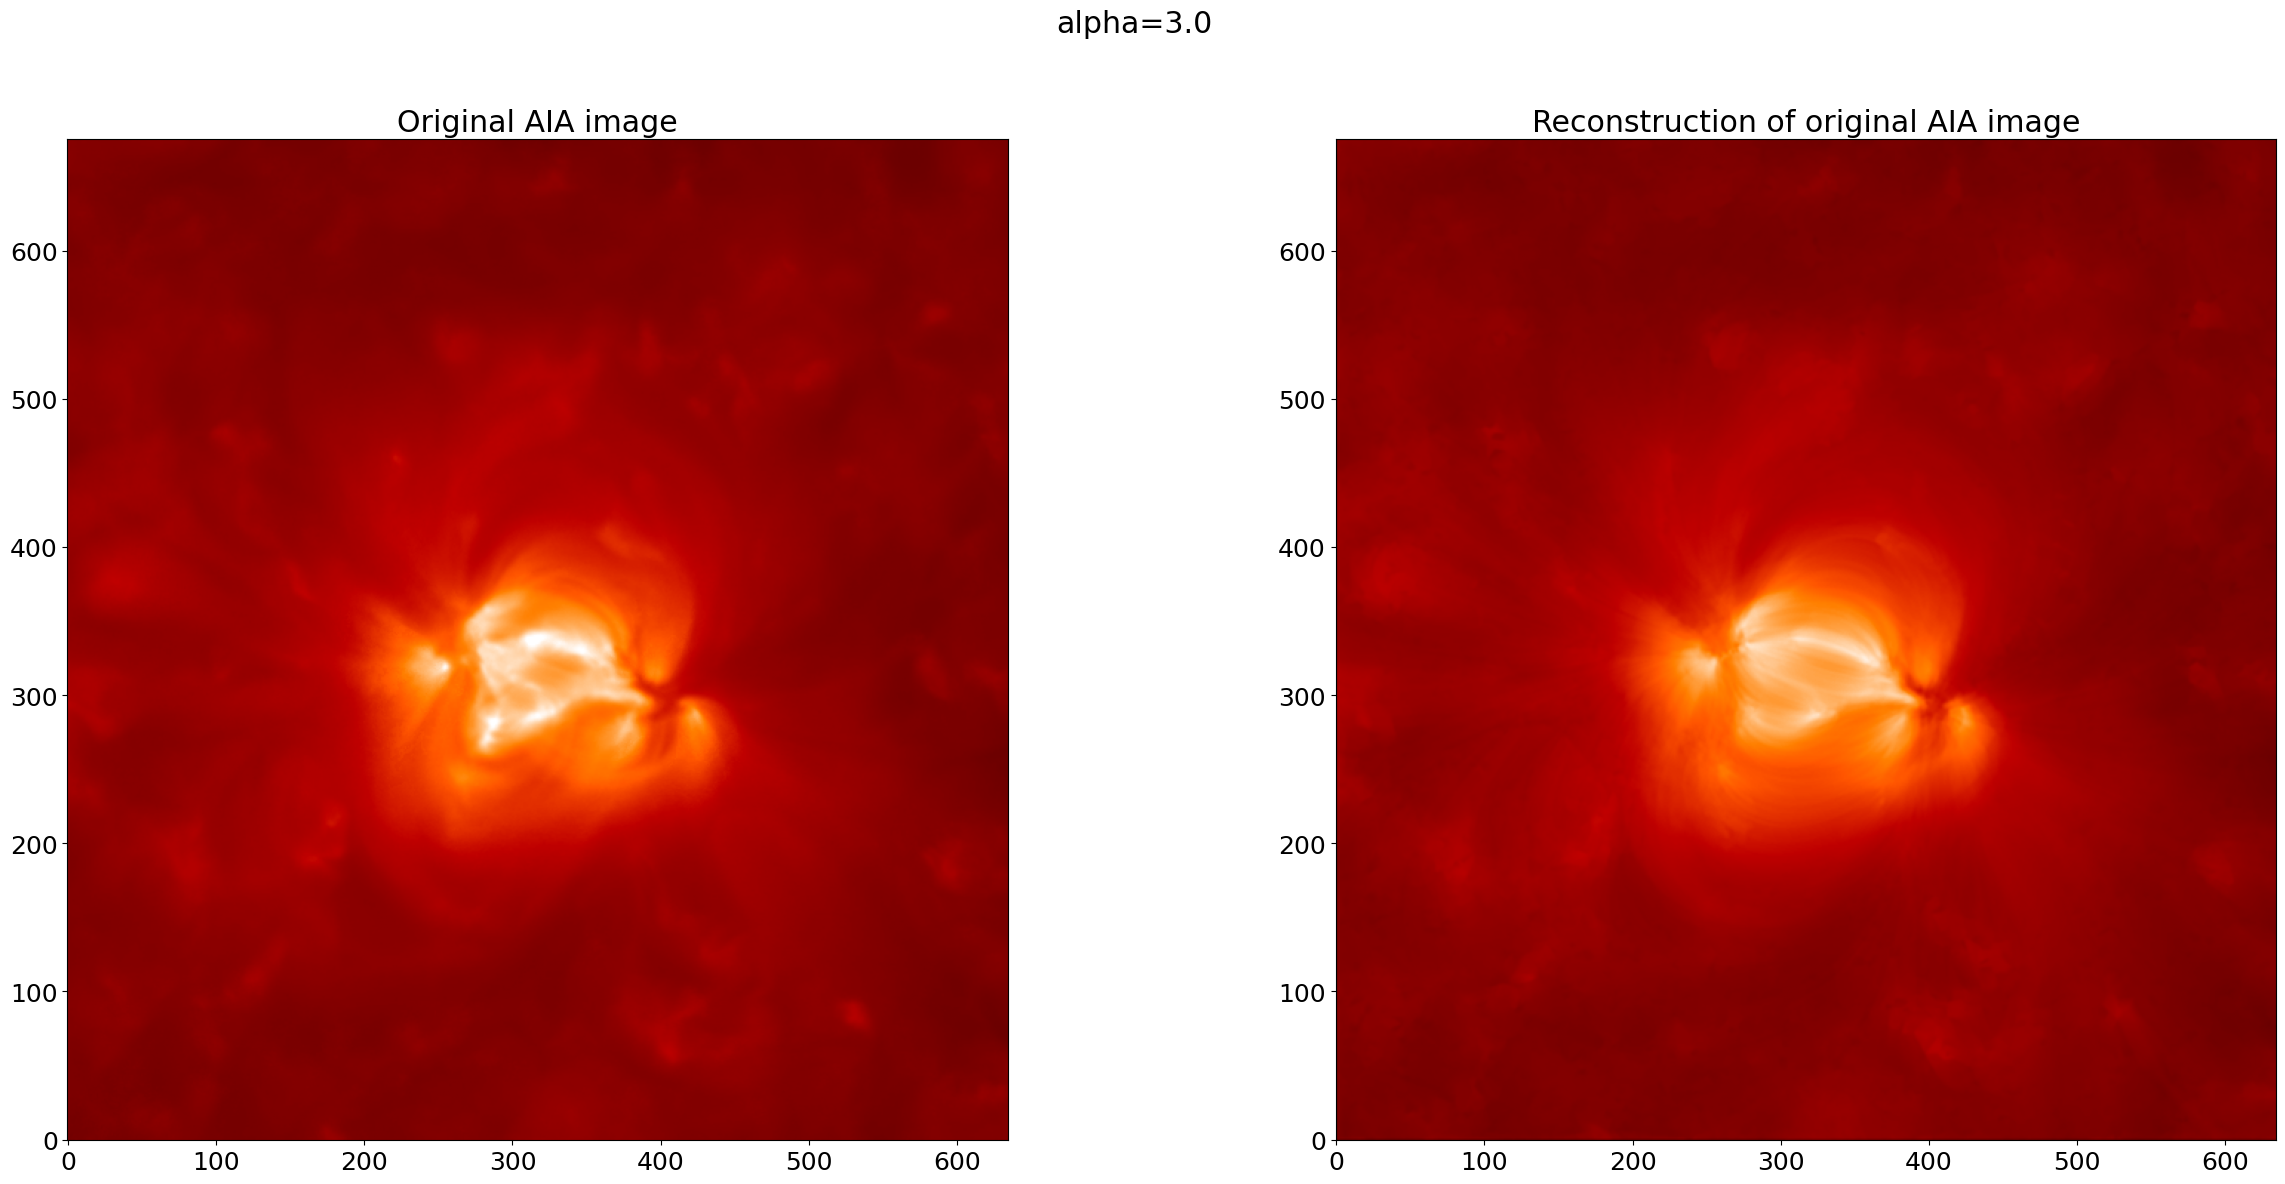

In [12]:
data_corr = emis_config['map'].data
gfac = 1.0/2.8

solution = em3d_output['solution']
soln = copy.deepcopy(solution)/emis_config['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(emis_config['loop_weights']*soln)).reshape(emis_config['map'].data.shape)

pltmax = 1000000

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(data_corr**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [13]:
import reconstruct_2comp_3Dloops 
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import general_fwdmat

amat_savefile = os.path.join(save_dir,'amat_heating_config_a'+alphastr+'.npz')
print(amat_savefile)

limb_mask_load = np.load(limb_savefile)

if run_amat_gen:
    amat_gen, modelinput_gen = general_fwdmat(emis_map, loopid_info, magnetogram, vox_mask=limb_mask_load['arr_0'], loud=False, bin_fac=1, psf_size_px=0.5)
    
    modelinput_gen.pop('map')
    np.savez_compressed(amat_savefile,
                       # Sparse matrix components
                       amat_data=amat_gen.data,
                       amat_indices=amat_gen.indices,
                       amat_indptr=amat_gen.indptr,
                       amat_shape=amat_gen.shape,
                       # modelinput_gen
                       vox_xy2=modelinput_gen['vox_xy2'],
                       psfnorm=modelinput_gen['psfnorm'],
                       psfnorm2=modelinput_gen['psfnorm2'],
                       rsun_cm=modelinput_gen['rsun_cm'])
else:
    from scipy.sparse import csc_matrix
    amat_heating_config = np.load(amat_savefile)
    amat_gen = csc_matrix(
        (amat_heating_config['amat_data'], amat_heating_config['amat_indices'], amat_heating_config['amat_indptr']), 
        shape=amat_heating_config['amat_shape'])

../files/save/amat_heating_config_a3.0.npz


In [14]:
heating_path = os.path.join('../CROBAR-heating/heating_modules/')
path.append(heating_path)

note: we are not using the most up-to-date version of the repository. Instead, to have the following work correcly, you need to install/revert to commit `608ed0f16ba705bd0d92d34a9223b5bfc820549d`. This version will have the correct heating_modules.

In [15]:
import loopset
importlib.reload(loopset)

dummy_mags = [0*vec[:,1] for vec in fieldlines_filter]
loopnames = np.copy(loopid_info['loopnames']).tolist() # put this into loopset (?)
ar = loopset.loopset.get_loops(fieldlines_filter,dummy_mags,lengths_filter,loopnames=loopnames)

In [16]:
loop_volumes = loop_areas['area_norms']*loop_areas['loop_amaxes']*loopid_info['looplengths'][0:nloops]
loopid_info['loop_volumes']=loop_volumes

In [17]:
#path.append("../supplementary_modules")
from processify import processify
import volumetric_poisson_powerlaw_nanoflares as vppnf


importlib.reload(vppnf)
heating_model = vppnf.volumetric_poisson_powerlaw_nanoflares(loopid_info)

In [19]:
#t_tot = 1.5e4*u.s
t_tot = 86400*u.s # 24hrs
heat_fac = 0.6 #140/27/7 # Too large compared to previous runs by a factor for 540, for some reason?

In [20]:
hmap_dict = np.load(em3d_savefile)
print(hmap_dict.keys())
hmap = hmap_dict['hmap']*(heat_fac/(u.erg/u.s/u.cm**3))

#hmap = em3d*limb_mask
hmx = vox0[0]+hmap_dict['xa']*dvox[0]
hmy = vox0[1]+hmap_dict['ya']*dvox[1]
hmz = vox0[2]+hmap_dict['za']*dvox[2]

KeysView(NpzFile '../files/save/hmap_cube_bindown3.npz' with keys: hmap, xa, ya, za)


In [21]:
heating_options = {
	'duration':200.0*u.s,
	'emin':2.0e22*u.erg,
	'emax':1.0e26*u.erg,
	'index': -2.8,
	'h_rate':(5e5*u.erg/u.cm**2/u.s)*0.05,
	't_tot':t_tot,
	'nt':np.round((t_tot/(25*u.s)).value).astype('int32'),
	'stress_level':1, # Doesn't do anything in this code
	'z0':25.0*dvox[2], #540e6,#6000e6,
	'dz0':15.0*dvox[2],#540e6,#2000e6,
	'event_size':np.array(dvox)*5,
	'Bfield_yt':None,
	'nloops':nloops,
	'magnetogram':np.transpose(magnetogram.data),
	'loopnames':loopid_info['loopnames'],
	#'heatmap':1.5*hmap/(u.erg/u.s/u.cm**3),
	'heatmap':hmap,
	'hmxyz':(hmx.astype('float32'),hmy.astype('float32'),hmz.astype('float32')),
	'heating_distribution_name':'../heating_distribution.save',
	'heatmap_factor':1.0,
	'loop_closed':loopid_info['loop_closed']
}

In [22]:
gamma_str = str(abs(heating_options['index']))
heat_str = str(heat_fac)

heat_dir = os.path.join(save_dir,'heating')
heatdic_savefile = os.path.join(heat_dir,'heatdict_g'+gamma_str+'_a'+alphastr+'_h'+heat_str+'.npz')
print(gamma_str, heat_str, heatdic_savefile)

2.8 0.6 ../files/save/heating/heatdict_g2.8_a3.0_h0.6.npz


In [23]:
if heating_model_gen:
    heating_model.generate_events(heating_options)
    heatdict = heating_model.create_events_dict()
    np.savez_compressed(heatdic_savefile, **heatdict)
else:
    heatdict = dict(np.load(heatdic_savefile),allow_pickle=False)
    heating_model.restore_events(heatdict)

Generating heating events:   0%|          | 0/8000 [00:00<?, ?chunk/s]

Done with chunk  0  out of  8000 ,  0.3733372688293457  seconds elapsed
Done with chunk  400  out of  8000 ,  122.97607612609863  seconds elapsed
Done with chunk  800  out of  8000 ,  300.9200162887573  seconds elapsed
Done with chunk  1200  out of  8000 ,  466.72318410873413  seconds elapsed
Done with chunk  1600  out of  8000 ,  634.0999732017517  seconds elapsed
Done with chunk  2000  out of  8000 ,  804.3933560848236  seconds elapsed
Done with chunk  2400  out of  8000 ,  982.9082622528076  seconds elapsed
Done with chunk  2800  out of  8000 ,  1174.9669642448425  seconds elapsed
Done with chunk  3200  out of  8000 ,  1409.124852180481  seconds elapsed
Done with chunk  3600  out of  8000 ,  1693.2306442260742  seconds elapsed
Done with chunk  4000  out of  8000 ,  1993.814543247223  seconds elapsed
Done with chunk  4400  out of  8000 ,  2297.3356840610504  seconds elapsed
Done with chunk  4800  out of  8000 ,  2598.114669084549  seconds elapsed
Done with chunk  5200  out of  8000 ,

7/22 EOD: track location of heating along loop - for HYDRAD

volumetric... `heat_chunk` 2D array (space, time) (?)

In [24]:
synthesizAR_path = os.path.join('../synthesizAR/')
path.append(synthesizAR_path)
import synthesizAR.interfaces.ebtel as ebtel

ebtel_config_template = ebtel_path+"config/ebtel.example.cfg.xml"

run_dir = '../files/runs/'
hydro_config_dir = run_dir+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}/hydro_config/'
hydro_results_dir = run_dir+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}/hydro_results/'

#hydro_config_dir = rundir_path+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}_rlon/hydro_config/' # rad loss on
#hydro_results_dir = rundir_path+f'heat_config_runs_h{heat_fac}_g{abs(heating_options['index'])}_rlon/hydro_results/'

ih = ebtel.util.read_xml(ebtel_config_template) # import read_xml
base_config = ih
base_config['c1_cond0'] = 6.0
base_config['total_time'] = t_tot
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1.0e-7
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0
base_config['use_power_law_radiative_losses'] = True
base_config['save_terms'] = True

In [25]:
import ebtel_interface_lowmem
importlib.reload(ebtel_interface_lowmem)
from ebtel_interface_lowmem import ebtel_interface_lowmem as eil

In [26]:
ebtel_interface = eil(base_config, heating_model, hydro_config_dir, hydro_results_dir)
ar.configure_loop_simulations(ebtel_interface)

In [27]:
print('Total heating: ',np.sum(heating_model.loop_heating))

Total heating:  1.242498e+29


3595.1853


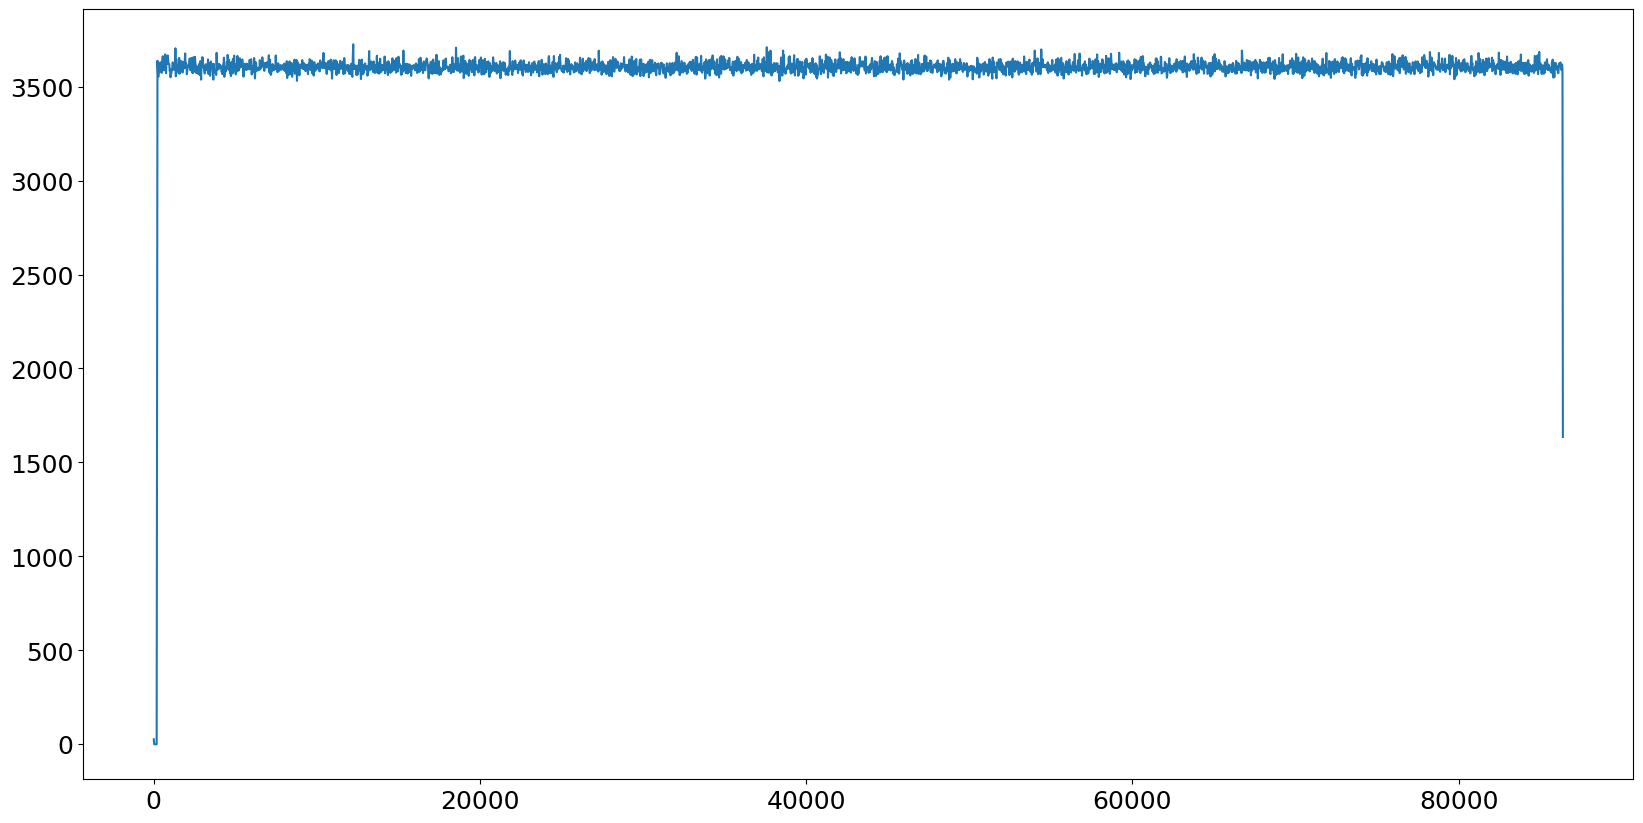

In [28]:
plt.figure(figsize=[20,10])
plt.plot(heating_model.times,np.sum(heating_model.loop_heating,axis=0)/1.0e22)
print(np.mean(np.sum(heating_model.loop_heating,axis=0)/1.0e22))

okay! to run ebtel++ using the following subprocess (e.g. `bin/ebtel++.run`) you need to install via 

`git clone https://github.com/<your-user-name>/ebtelPlusPlus.git` using `ae4a69153f38b95a341c54dad3c199d8fef088c0`. You will need `boost` and `scons` as well, where you can then run

```
$ git clone https://github.com/rice-solar-physics/ebtelPlusPlus.git
$ cd ebtelPlusPlus
$ scons
$ bin/ebtel++.run
```

note: if you install boost via brew, and depending on the version you use, you will need to approprialty update the `SConstruct` file to point to this install. Something like:

```
if 'darwin' in sys.platform:
    print("Using Mac OS X compile options.")
    env.Append(CPPPATH=['/opt/local/include', '/usr/include/malloc','/opt/homebrew/include/'])
    env.Append(LIBS=['boost_program_options'])
    env.Append(LIBPATH=['/opt/homebrew/lib'])
```

you might also need to set `cxx_flags = ['-std=c++14',]`

In [29]:
if(run_ebtel):
	def ebtel_runner(loop):
		#print(loop.name)
		subprocess.call([ebtel_bin_path,
			'-c',loop.hydro_configuration['config_filename']])
	
	results = []
	for loop in tqdm(ar.loops):
	##for loop in ar.loops:
	    ebtel_runner(loop)
    

  0%|          | 0/9291 [00:00<?, ?it/s]

In [30]:
# These cells should load and make a plot of the output:
loop_parameter_filename = run_dir+'ebtel_runs/loop_parameters.h5' # not currently needed in .load_loop_simulations
from load_terms import load_terms

print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
ar.load_loop_simulations(ebtel_interface,loop_parameter_filename)
ebtelterms = []
for loop in ar.loops: ebtelterms.append(load_terms(loop))
print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

Memory usage: 40915861504 (kb)
Memory usage: 59004862464 (kb)


Memory usage: 59005321216 (kb)


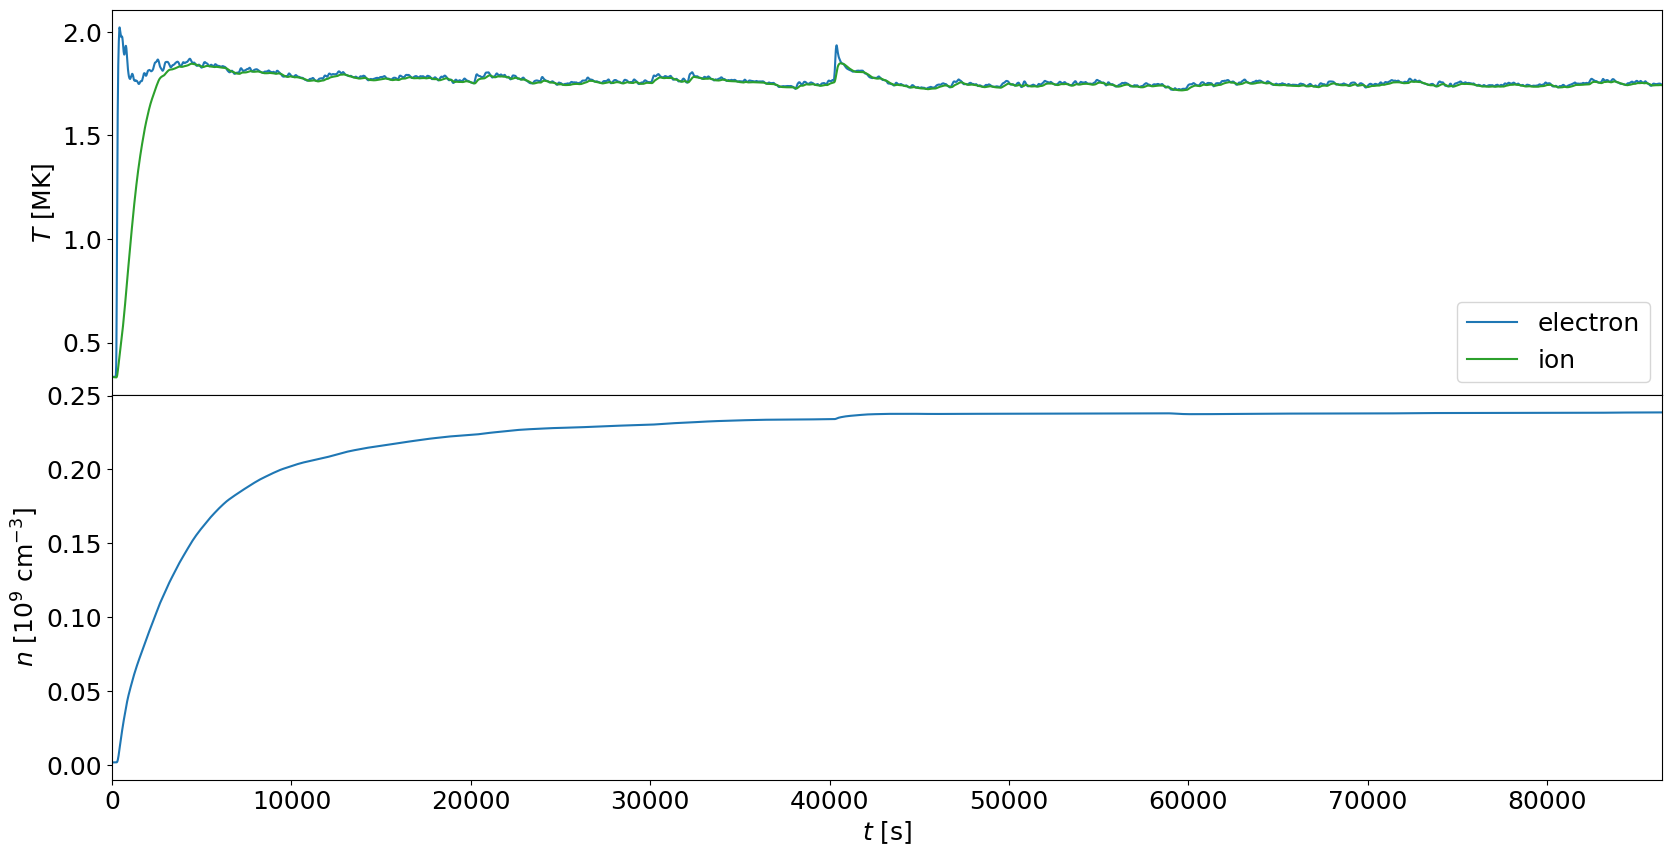

In [31]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
loop=ar.loops[loopid_info['voxel_loopids'][1000,1000,700]]
axes[0].plot(loop.time,loop.electron_temperature/1.0e6,color='C0',label='electron')
axes[0].plot(loop.time,loop.ion_temperature/1.0e6,color='C2',label='ion')
axes[0].legend()
axes[1].plot(loop.time,loop.density/1e9,color='C0')
axes[0].set_xlim([0,base_config['total_time']/u.s])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')
print('Memory usage: %s (kb)' % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

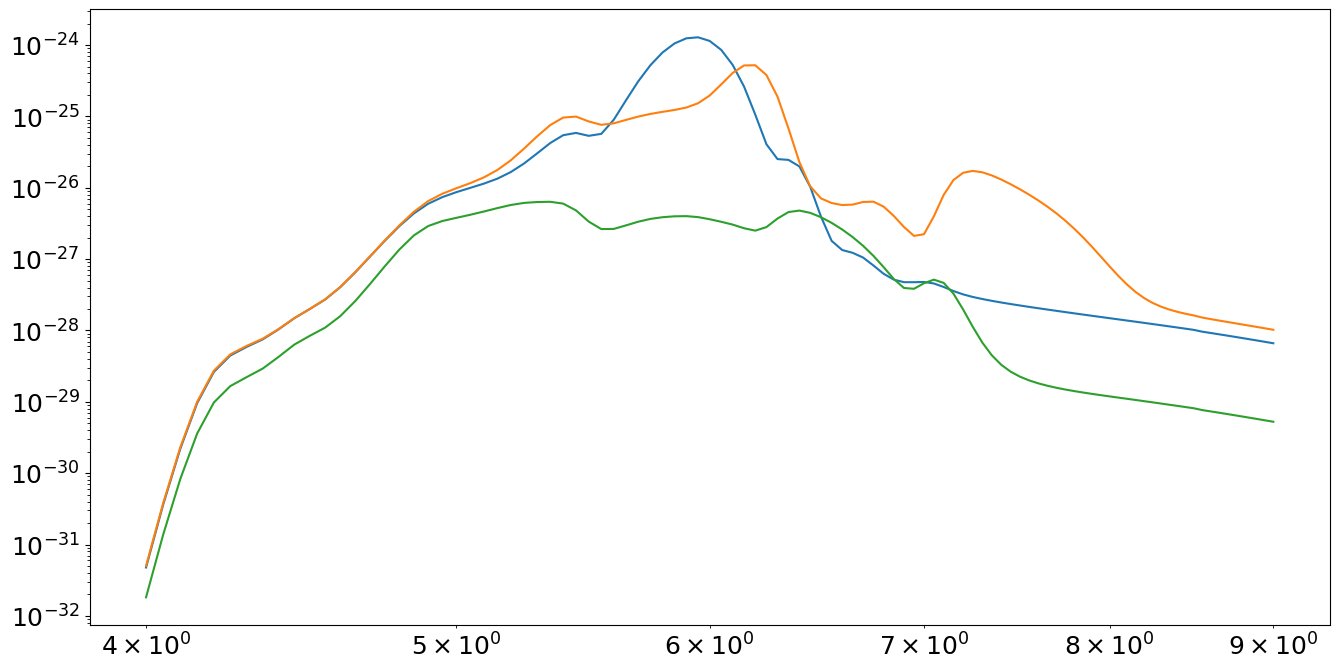

In [32]:
import make_channel_image
importlib.reload(make_channel_image)

import aia
importlib.reload(aia)
from aia import aia_temperature_response

tr171_logt,tr171 = aia_temperature_response(None,channel='AIA171_THIN')
tr193_logt,tr193 = aia_temperature_response(None,channel='AIA193_THIN')
tr335_logt,tr335 = aia_temperature_response(None,channel='AIA335_THIN')

plt.loglog(tr171_logt,tr171)
plt.loglog(tr193_logt,tr193)
plt.loglog(tr335_logt,tr335)

In [33]:
aia_dir = '../files/data'

import glob
fits_files = glob.glob(os.path.join(aia_dir, "*.fits"))
fits_files

aia193dat_path = None
aia335dat_path = None
aia171dat_path = None
magnetogram_path = None

for file_path in fits_files:
    filename = os.path.basename(file_path).lower()
    
    if 'aia' in filename and '193' in filename:
        aia193dat_path = file_path
    elif 'aia' in filename and '335' in filename:
        aia335dat_path = file_path
    elif 'aia' in filename and '171' in filename:
        aia171dat_path = file_path

aia193map = Map(aia193dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia193map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia193map.coordinate_frame)
aia193map = Map(aia193dat_path).submap(blc,top_right=trc)

aia171map = Map(aia171dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia171map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia171map.coordinate_frame)
aia171map = Map(aia171dat_path).submap(blc,top_right=trc)

aia335map = Map(aia335dat_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=aia335map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=aia335map.coordinate_frame)
aia335map = Map(aia335dat_path).submap(blc,top_right=trc)

In [34]:
aia_time_sec = np.arange(0,t_tot.value+12,12,dtype=int)

In [35]:
base_time = datetime(2020, 4, 28, 0, 0, 0)  # 2020-04-28T00:00:00

time_offset = aia_time_sec[-1]

new_time = base_time + timedelta(seconds=int(time_offset))

date_obs_string = new_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] 

meta = copy.deepcopy(emis_map.meta)
meta['date-obs'] = date_obs_string
meta['date-obs']

'2020-04-29T00:00:00.000'

In [36]:
cmap_aia = plt.cm.gray  # Or any other colormap you prefer
cmap_aia.set_bad(color='black')

In [37]:
import warnings
from astropy.io.fits.verify import VerifyWarning

# Suppress just this specific warning
warnings.filterwarnings('ignore', category=VerifyWarning, 
                       message=".*Invalid 'BLANK' keyword in header.*")

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [38]:
import ebtel_profiles
importlib.reload(ebtel_profiles)
from ebtel_profiles import variable_profile

In [39]:
area_config = dict(np.load(area_savefile),allow_pickle=False)

In [40]:
times = np.arange(round(86400/12)+1)*12 # np.linspace(0,86400,12)
profile_evaluator = variable_profile(nvox, dvox, times, ar.loops, area_config)

  0%|          | 0/9291 [00:00<?, ?it/s]

  0%|          | 0/9291 [00:00<?, ?it/s]

In [41]:
aia335map.meta['wavelnth']

335

In [42]:
def image_gen(t, temps, rhos, trlogt, tresp, base_map, channel, fits_dir, image_dir, save_fits=True, save_img = True):
    dimension_factor = np.prod(dvox[0:2])/(asec_cm*asec_cm*base_map.meta['CDELT1']*base_map.meta['CDELT2'])
    profs = np.interp(np.log10(temps),trlogt,tresp)*rhos**2
    image = base_map.meta['exptime']*amat_gen.T.dot(profs.flatten()).reshape(base_map.data.shape)*dvox[2]*dimension_factor
    
    # add noise
    image = aia_noise(image, channel=channel)
    
    # save fits
    new_time = base_time + timedelta(seconds=int(t))
    date_obs_string = new_time.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]	
    save_string = 'ebtel_'+channel.split('_')[0]+'_'+new_time.strftime('%Y%m%dT%H%M%S')+'.fits'
    
    meta = copy.deepcopy(base_map.meta)
    meta['date-obs'] = date_obs_string
    meta['wavelnth'] = meta['wavelnth']
    meta['wave_str'] = channel # f'{meta['wavelnth']}_THIN'
    
    temp_map = sunpy.map.Map(image, meta)
    center_x, center_y = temp_map.data.shape[1] // 2, temp_map.data.shape[0] // 2
    
    x_start = center_x - 256
    x_end = center_x + 255  
    y_start = center_y - 256
    y_end = center_y + 255
    
    bl = temp_map.pixel_to_world(x_start*u.pixel,y_start*u.pixel)
    tr = temp_map.pixel_to_world(x_end*u.pixel,y_end*u.pixel)
    
    outmap = temp_map.submap(bl, top_right=tr)
    
    if save_fits:
        outmap.save(f'{fits_dir}/{channel.split('_')[0]}/{save_string}', overwrite=True)

    
    # plot and save 
    fig = plt.figure(figsize=(8,8))		
    plt.imshow(np.clip(outmap.data,0,None)**gfac,cmap=cmap_aia, vmin=0, vmax=3000**gfac)
    plt.title(channel+' '+date_obs_string)	
    #fig.savefig(image_dir + 'ebtel_'+channel+'_'+new_time.strftime('%Y%m%dT%H%M%S')+'.png')
    img_string = 'ebtel_'+channel.split('_')[0]+'_'+new_time.strftime('%Y%m%dT%H%M%S')+'.png'
    if save_img:
        fig.savefig(f'{image_dir}/{channel.split('_')[0]}/{img_string}',dpi=150)
        plt.close()

In [43]:
run_batch=True

fits_dir = f'../files/ebtel_fits/g{gamma_str}'
os.makedirs(f'{fits_dir}/AIA171', exist_ok=True)
os.makedirs(f'{fits_dir}/AIA193', exist_ok=True)
#os.makedirs(f'{fits_dir}/AIA335', exist_ok=True)

image_dir = f'../files/ebtel_figs/g{gamma_str}'
os.makedirs(f'{image_dir}/AIA171', exist_ok=True)
os.makedirs(f'{image_dir}/AIA193', exist_ok=True)
#os.makedirs(f'{image_dir}/AIA335', exist_ok=True)

In [45]:
fits_dir,image_dir

('../files/ebtel_fits/g2.8', '../files/ebtel_figs/g2.8')

In [46]:
nl = 255
temps = np.zeros([nloops+1,nl]); rhos = np.zeros([nloops+1,nl])#emprofs_171 = np.zeros([nperblock,nloops+1,nl],dtype=np.float32)
if run_batch:
	for i in tqdm(np.arange(len(times))): #range(0,len(times)):
		for j in range(0,nloops):
			temp, rho, pres, g = profile_evaluator.calculate(j, i)
			temps[j,:]=temp; rhos[j,:]=rho
            
		image_gen(times[i], temps, rhos, tr171_logt, tr171, aia171map, 'AIA171_THIN',fits_dir,image_dir)
		image_gen(times[i], temps, rhos, tr193_logt, tr193, aia193map, 'AIA193_THIN',fits_dir,image_dir)
		#image_gen(times[i], temps, rhos, tr335_logt, tr335, aia193map, 'AIA335_THIN',fits_dir,image_dir)

  0%|          | 0/7201 [00:00<?, ?it/s]

In [5]:
gamma_str='2.8'
fits_dir = f'../files/ebtel_fits/g{gamma_str}'



files_171 = sorted(glob.glob(f'{fits_dir}/AIA171/*'))
print(f" 171 files: {len(files_171)}")
files_193 = sorted(glob.glob(f'{fits_dir}/AIA193/*'))
print(f"193 files: {len(files_193)}")

 171 files: 7201
193 files: 7201
